In [1]:
%cd ..

/home/dawood/Workspace/compoundGAN


In [2]:
import torch
import networkx as nx
import numpy as np
from tqdm import tqdm

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from PIL import Image

from data.zinc import mol2graph, Library, ZINC250K

from models.network import CVAEF

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

/home/dawood/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/dawood/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/dawood/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/dawood/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/dawood/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indi

In [3]:
dataset = ZINC250K('/home/dawood/Datasets/ZINC250K/data.csv')

In [4]:
#state_dict = torch.load('/home/dawood/model_500.weights')#
state_dict = torch.load('./model.weights')

In [38]:
enc = Encoder(59, 13, 256)
enc = enc.cuda()
enc.load_state_dict(state_dict['enc_state_dict'])
enc = enc.eval()

gen = Generator(256, [44, 7, 3, 3, 2], [5, 2, 2, 4], 1)
gen = gen.cuda()
gen.load_state_dict(state_dict['gen_state_dict'])
gen = gen.eval()

In [39]:
# smiles = 'C1=CC=CC=C1'
# smiles = 'C'
# smiles='CC(=O)NC1=CC=CC=C1C(=O)O'
# smiles='C1=CC=C(C(=C1)C(=O)OC2=CC=CC=C2C(=O)O)O'
# smiles='CCC[NH2+]C1CCC(O)(Cc2nc(C)cs2)CC1'
# smiles='C#CCOCC1CCN(C(=O)c2ccc(S(=O)(=O)N3CCCC[C@H]3C)cc2)CC1'
# smiles='Cc1cccc2sc(NC(=O)[C@H](C)N3C(=O)[C@@H]4CC=CC[C@H]4C3=O)nc12'
# smiles='Cc1cc(C(=O)Nc2ccc(OCC(N)=O)cc2)c(C)n1C1CC1'
# smiles='CCOc1ccc2nc(N(C[C@@H]3CCCO3)C(=O)c3ccccc3S(C)(=O)=O)sc2c1'
# smiles='COc1cc(C(=O)N(Cc2cccc(F)c2)[C@H]2CCS(=O)(=O)C2)cc(OC)c1OC'
# mol = Chem.MolFromSmiles(smiles)
# Draw.MolToMPL(mol); plt.show()
# G, atom_feats, bond_feats = mol2graph(mol)
# G.to(torch.device('cuda:0'))
# mu, var = enc(G)

In [40]:
def run_network(smiles, draw=True):
    mol = Chem.MolFromSmiles(smiles)

    G, atom_feats, bond_feats = mol2graph(mol)
    G.to(torch.device('cuda:0'))
    mu, var = enc(G)

    z = enc.reparameterize(mu, var, no_noise=False)
    z = mu
    #z = torch.randn_like(z)
    node_list, edge_list = gen(z.unsqueeze(0), 100)
    nodes = []
    edges = []

    bondtype_list  = [
            Chem.rdchem.BondType.SINGLE,
            Chem.rdchem.BondType.DOUBLE,
            Chem.rdchem.BondType.TRIPLE,
            Chem.rdchem.BondType.AROMATIC
    ]

    chirality_list = [
        Chem.rdchem.BondStereo.STEREONONE, 
        Chem.rdchem.BondStereo.STEREOANY,
        Chem.rdchem.BondStereo.STEREOZ,
        Chem.rdchem.BondStereo.STEREOE
    ]

    idx_map = {}
    pred_mol = Chem.RWMol()
    for i, node in enumerate(node_list):
        conf =  node[0][1].item()
        atom_id = Library.atom_list[node[0][0].item()]
        charge  = Library.charge_list[node[1][0].item()]
        electron = Library.electron_list[node[2][0].item()]
        try:
            chirality = Library.chirality_list[node[3][0].item()]
        except IndexError:
            chirality = ''
        aromatic =  Library.electron_list[node[4][0].item()]
        
        nodes.append(atom_id)

        a = Chem.Atom(atom_id)
        
        if chirality=='R': a.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CW)
        elif chirality=='S': a.SetChiralTag(Chem.ChiralType.CHI_TETRAHEDRAL_CCW)
        a.SetFormalCharge(charge)
        a.SetNumRadicalElectrons(electron)
        a.SetIsAromatic(aromatic)
        idx = pred_mol.AddAtom(a)
        idx_map[i] = idx
        
        e = []
        _edges = edge_list[i]
        for j, edge in enumerate(_edges):
            bond_type = edge[0][0].item()
            conjugated = edge[1][0].item()
            ring = edge[2][0].item()
            chirality = edge[3][0].item()

            if bond_type == 0:
                continue

            e.append((idx, j))
            edges.append(((j, i), bond_type))

            bond_type = bondtype_list[bond_type - 1]
            bond = pred_mol.AddBond(idx_map[i], idx_map[j], bond_type)
            bond = pred_mol.GetBondWithIdx(bond - 1)
            bond.SetStereo(chirality_list[chirality])
            bond.SetIsConjugated(conjugated)
    
    return nodes, edges

    fp_gt   = FingerprintMols.FingerprintMol(mol)
    fp_pred = FingerprintMols.FingerprintMol(pred_mol)
    similarity = DataStructs.FingerprintSimilarity(fp_gt, fp_pred)
    
    try:
        Chem.SanitizeMol(pred_mol, catchErrors=True)
        if draw:
            img = Draw.MolsToGridImage([mol, pred_mol], molsPerRow=2, subImgSize=(400, 400), legends=['GT', 'Pred'])
            plt.figure(figsize=(10, 10))
            plt.imshow(img, interpolation='bilinear')
        valid = 1
    except Exception as e:
        print(e)
        if draw:
            Draw.MolToMPL(mol, size=(250, 250)); 
        valid = 0
      
    if draw:
        plt.axis('off')
        plt.show()
    
    return edge_list, node_list, z, valid, similarity

In [41]:
idx = torch.randint(len(dataset), (1,))
smiles = dataset.data[idx]
#edge_list, node_list, emb, valid, similarity = run_network(smiles)
node_list, edge_list = run_network(smiles)

In [42]:
emb_list = []
valid_list = []
sim_list = []

processed = []
for i in tqdm(range(6000)):
    while True:
        idx = torch.randint(len(dataset), (1,))
        if idx not in processed: break
    processed.append(idx)
    smiles = dataset.data[idx]
    emb, valid, similarity = run_network(smiles, draw=False)
    emb_list.append(emb.data.cpu().numpy())
    valid_list.append(valid)
    sim_list.append(similarity)

  0%|          | 0/6000 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 3, got 2)

In [43]:
tsne = TSNE(n_components=2, random_state=10)
emb_2d = tsne.fit_transform(emb_list)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

NameError: name 'emb_2d' is not defined

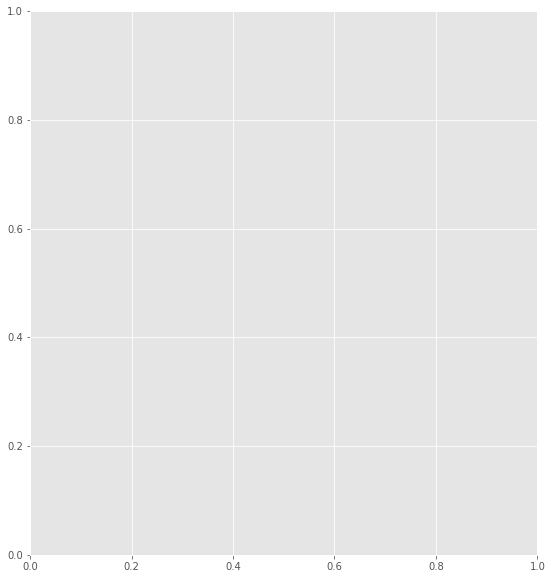

In [44]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=valid_list, s=20, cmap='RdBu', alpha=0.7)
plt.colorbar()

plt.subplot(122)
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=sim_list, s=20, alpha=0.7)
plt.colorbar()
plt.show()

plt.show()

/home/dawood/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


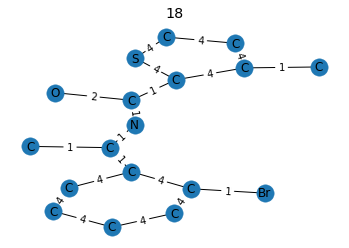

In [45]:
predicted = nx.Graph()
for i, n in enumerate(node_list):
    predicted.add_node(i, atom=n)
for e, bt in edge_list:
    predicted.add_edge(*e, bond_type=bt)
    
plt.figure()
plt.title(len(node_list))
#pos = nx.spring_layout(predicted)
pos = nx.kamada_kawai_layout(predicted)
nx.draw(predicted, pos)
node_labels = nx.get_node_attributes(predicted, 'atom')
nx.draw_networkx_labels(predicted, pos, labels=node_labels)
edge_labels = nx.get_edge_attributes(predicted, 'bond_type')
nx.draw_networkx_edge_labels(predicted, pos, edge_labels=edge_labels)
plt.show()

In [35]:
mol